In [51]:
using Plots
using SimpleSolvers

using LinearAlgebra
using LogExpFunctions
using WassersteinDictionaries

using Optim, LineSearches

In [63]:
const d = 2
const n = 32

x₁ = collect(range(0,1,length=n))
x₂ = collect(range(0,1,length=n))

S = 4;

In [64]:
c = WassersteinDictionaries.get_cost_matrix_separated(n, d);

In [437]:
t = 0:0.1:1
a = 0.5
ν = 2e-3

function _p(x,t,a,ν)
    x₀ = [0.25; 0.25] + t*a*[1; 1]
    σ = sqrt(0.002 + 2*t*ν)
    
    1/(2*pi*σ^2) * exp(-norm(x - x₀)^2/(2*σ^2))
end

Sₜ = length(t)*length(a)*length(ν)

11

In [438]:
p = [zeros(n,n) for _ in 1:Sₜ] # input histograms

for s in 1:Sₜ
    for i in 1:n
        for j in 1:n
            p[s][i,j] = _p([x₁[i]; x₂[j]], t[s], a, ν)
        end
    end
    p[s] ./= sum(p[s])
end

c_max = maximum(maximum.(p));

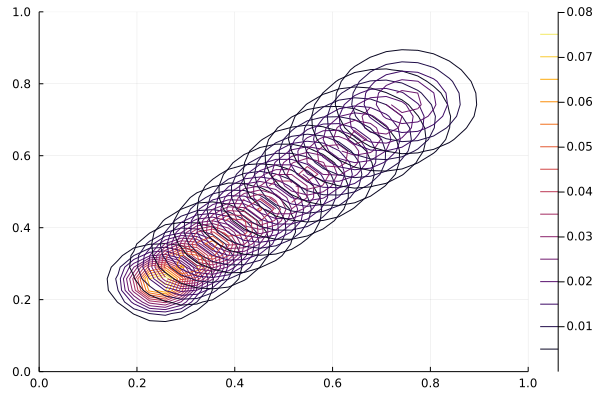

In [439]:
contour(x₁, x₂, p)

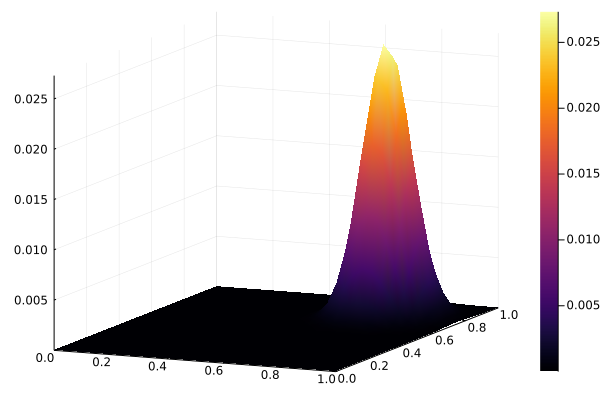

In [440]:
surface(x₁, x₂, p[end])

In [459]:
ε = 1e-2

SP = SinkhornParameters(64, ε)
SPB = SinkhornParameters(64, ε)

SP.averaged_updates = false
SP.debias = true

k = WassersteinDictionaries.get_gibbs_matrix(c, ε)

α = [ p[1], p[end] ]
α_indices = [ 1, Sₜ ]
S = 2

a₀ = ones(size(α[1])); b₀ = ones(size(α[1]))
d₀₁ = ones(size(α[1])); d₀₂ = ones(size(α[1]))

b_₀ = [ones(size(α[s])) for s in eachindex(α)] 
d₀ = ones(size(α[1]));

x_trace = []
y_trace = [];

In [480]:
function optimcallback(x, loss)
    #SP.update_potentials = true
    #SPB.update_potentials = true

    push!(y_trace, loss(x[end].metadata["x"]) )
    push!(x_trace, softmax(x[end].metadata["x"]))

    SP.update_potentials = false
    SPB.update_potentials = false

    SP.L = 32
    SPB.L = 32

    return false
end

optimcallback (generic function with 1 method)

In [482]:
caches = ( MC = MatrixCache(S,n), VMC = VectorMatrixCache(S,n), VC = VectorCache(S,n) )

ΔW = zeros(Sₜ)
λ = [zeros(S) for _ in 1:Sₜ]


for s in 1:Sₜ

    q = p[s]

    a₀ .= 1; b₀ .= 1
    d₀₁ .= 1; d₀₂ .= 1

    for s_ in 1:S
        b_₀[s_] .= 1
    end
    d₀ .= 1

    function w2_loss_separated(w::Vector{T}) where T
        μ_λ = sinkhorn_barycenter_separated(softmax(w), α, b_₀, d₀, k, SPB, caches)
        return abs( sinkhorn_dvg_separated(μ_λ, q, a₀, b₀, d₀₁, d₀₂, k, SP, caches) )
    end

    SP.L = 32
    SPB.L = 32

    brk = false
    for s_α in eachindex(α_indices)
        if s == α_indices[s_α]
            λ[s][s_α] = 1
            ΔW[s] = 0.0
            brk = true
        end
    end

    if brk
        continue
    end

    result = optimize(  w2_loss_separated,
                        zeros(S),                     
                        LBFGS(  m=10, 
                                linesearch = LineSearches.BackTracking( c_1=1e-6, iterations = 100),
                                alphaguess = LineSearches.InitialStatic()),
                        Optim.Options(  callback = x -> optimcallback(x, w2_loss_separated),
                                        iterations = 16,
                                        allow_f_increases = true,
                                        store_trace = true,
                                        extended_trace = true,
                                        g_tol = 1e-5,
                                        f_tol = 1e-3),
                        autodiff=:forward   )

    wₒₚₜ = Optim.minimizer(result)
    λ[s] = softmax(wₒₚₜ)
    ΔW[s] = Optim.minimum(result)
end


In [483]:
ΔW

11-element Vector{Float64}:
 0.0
 3.1457424415662696e-7
 2.76473420556766e-6
 5.307538563444712e-6
 7.241486346219149e-6
 8.239304159454813e-6
 8.176763610978692e-6
 7.066033236878035e-6
 5.028453547844825e-6
 2.2343198202186296e-6
 0.0

In [484]:
λ

11-element Vector{Vector{Float64}}:
 [1.0, 0.0]
 [0.8999824071057521, 0.100017592894248]
 [0.7998971371760017, 0.20010286282399822]
 [0.6998368195187867, 0.30016318048121327]
 [0.599792641492885, 0.4002073585071149]
 [0.499763806680402, 0.5002361933195979]
 [0.3997486185869448, 0.6002513814130551]
 [0.2997461499972263, 0.7002538500027736]
 [0.1997578081176667, 0.8002421918823334]
 [0.09978421659458488, 0.9002157834054152]
 [0.0, 1.0]

In [489]:
pᵣ = copy(p)
for s in 1:Sₜ
    pᵣ[s] = sinkhorn_barycenter_separated(λ[s], α, b_₀, d₀, k, SPB, caches)
end

In [490]:
ΔL₁ = [ norm(p[s]-pᵣ[s],1) for s in 1:Sₜ ]

11-element Vector{Float64}:
 0.029293955924100654
 0.004480247156965409
 0.02257525653061522
 0.031713950601664764
 0.035622681426090784
 0.03427047774076381
 0.031016315524440487
 0.025537293123421994
 0.0184691797051905
 0.010039032638773895
 0.001260132774397989

In [491]:
sum(ΔL₁)./Sₜ, sum(ΔW)./Sₜ 

(0.022207138467856862, 4.21574615770574e-6)

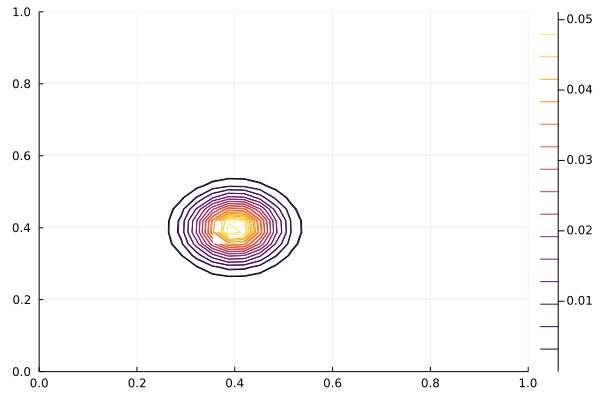

In [492]:
s_ = 4
contour(x₁, x₂, [p[s_], pᵣ[s_] ])

# SVD

In [469]:
Snap = zeros(n^2,Sₜ)

for s in 1:Sₜ
    Snap[:,s] .= reshape(p[s],n^2)
end

F = svd(Snap);

In [470]:
fieldnames(typeof(F))

(:U, :S, :Vt)

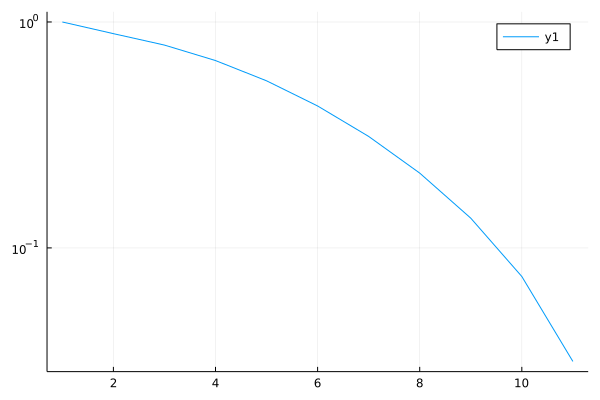

In [471]:
plot(F.S./F.S[1], yaxis = :log)

In [472]:
modes = [ reshape(F.U[:,s], (n,n)) for s in 1:Sₜ  ];

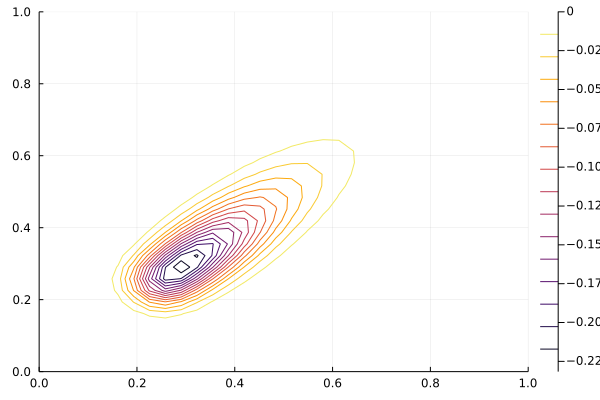

In [475]:
contour(x₁, x₁, modes[1])

In [476]:
Π = F.U[:,1:2] * F.U[:,1:2]';

In [477]:
pₛᵥ = [ reshape( Π * Snap[:,s], (n,n)) for s in 1:Sₜ ];

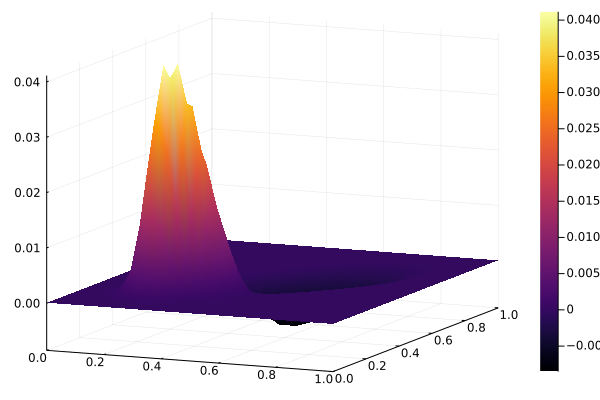

In [478]:
surface(x₁, x₁, pₛᵥ[1])

In [479]:
ΔL₁_svd = [ norm(p[s]-pₛᵥ[s],1) for s in 1:Sₜ ]

11-element Vector{Float64}:
 1.2884294693371376
 0.8167707540603734
 0.9708640174942229
 1.1765902415513745
 1.0392489539335732
 1.0056724664445356
 1.030304597087905
 1.097286644660403
 1.1601326967618923
 1.1832734368878284
 1.1461527011916053